In [4]:
from typing import Optional

from matplotlib import pyplot as plt
import numpy as np
import torch
import torch as th
from torch import Tensor, nn, optim

In [25]:
# Helper classes
class SelfAttention(nn.Module):
    def __init__(self, h_size, n_heads=4):
        super().__init__()
        self.h_size = h_size
        self.n_heads = n_heads
        
        self.mha = nn.MultiheadAttention(
            h_size, n_heads, dropout=0.0, add_zero_attn=False, batch_first=True
        )
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size)
        )

    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, attn_weighting = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value, attn_weighting

class CrossAttention(nn.Module):
    def __init__(self, q_size, kv_size, n_heads=4, skip_q=False):
        super().__init__()
        self.h_size = q_size
        self.skip_q = skip_q
        self.n_heads = n_heads

        self.mha = nn.MultiheadAttention(
            q_size,
            n_heads,
            dropout=0.0,
            add_zero_attn=False,
            batch_first=True,
            kdim=kv_size,
            vdim=kv_size,
        )
        self.ln_q = nn.LayerNorm([q_size])
        self.ln_kv = nn.LayerNorm([kv_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([q_size]),
            nn.Linear(q_size, q_size),
            nn.GELU(),
            nn.Linear(q_size, q_size)
        )

    def forward(self, q, kv):
        q_ln = self.ln_q(q)
        kv_ln = self.ln_kv(kv)
        attention_value, attn_weighting = self.mha(q_ln, kv_ln, kv_ln)
        if not self.skip_q:
            attention_value = attention_value + q
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value, attn_weighting


# Main class(es)
class Perceiver_GWT_GWWM(nn.Module):
    def __init__(
        self,
        *,
        input_dim,
        latent_type = "randn",
        latent_learned = True,
        num_latents = 8,
        latent_dim = 64,
        cross_heads = 1, # LucidRains's implm. uses 1 by default
        latent_heads = 4, # LucidRains's implm. uses 8 by default
        # cross_dim_head = 64,
        # latent_dim_head = 64,
        # self_per_cross_attn = 1, # Number of self attention blocks per cross attn.
        # Modality embeddings realted
        hidden_size = 512, # Dim of the visual / audio encoder outputs
        mod_embed = 0, # Dimensio of learned modality embeddings
        use_sa = False
    ):
        super().__init__()
        self.input_dim = input_dim
        self.num_latents = num_latents # N
        self.latent_dim = latent_dim # D
        self.latent_type = latent_type
        self.latent_learned = latent_learned

        self.mod_embed = mod_embed
        self.hidden_size = hidden_size
        self.use_sa = use_sa
        # Cross Attention
        self.ca = CrossAttention(latent_dim, input_dim + mod_embed,
            n_heads=cross_heads, skip_q=not use_sa) # skip_q if not using SA
        # Self Attention
        if self.use_sa:
            self.sa = SelfAttention(latent_dim, n_heads=latent_heads)
        # self.decoder = CrossAttention(self.h_size, self.s_size, skip_q=True)

        # Modality embedding
        if self.mod_embed:
            self.modality_embeddings = nn.Parameter(torch.randn(1, 1, mod_embed))
        
        # Latent vector, supposedly equivalent to an RNN's hidden state
        if latent_type == "randn":
            self.latents = torch.randn(1, num_latents, latent_dim)
            # As per original paper
            with th.no_grad():
                self.latents.normal_(0.0, 0.02).clamp_(-2.0,2.0)
        elif latent_type == "zeros":
            self.latents = torch.zeros(1, num_latents, latent_dim)
        
        self.latents = nn.Parameter(self.latents, requires_grad=latent_learned)

    def seq_forward(self, data, prev_latents):
        # TODO: a more optimal method to process sequences of same length together ?
        x_list, latents_list = [], []

        B_T, feat_dim = data.shape
        B = prev_latents.shape[0]
        T = B_T // B # TODO: assert that B * T == B_T
        latents = prev_latents.clone()

        data = data.reshape(B, T, feat_dim)
        masks = masks.reshape(B, T, 1)

        for t in range(T):
            x, latents = self.single_forward(data[:, t], latents, masks[:, t])

            x_list.append(x)
            latents_list.append(latents)
        
        # TODO: debug
        x_list = th.stack(x_list, dim=0).flatten(start_dim=0, end_dim=1) # [B * T, feat_dim]
        latents_list = th.stack(latents_list, dim=0).flatten(start_dim=0, end_dim=1) # [B * T, num_latents, latent_dim]

        return x_list, latents_list

    def single_forward(self, data, prev_latents):
        b = data.shape[0] # Batch size

        if data.dim() == 2:
            data = data.reshape(b, 2, self.hidden_size) # [B,1024] -> [B,2,512]
            
        if self.mod_embed:
            data = th.cat([data, self.modality_embeddings.repeat(b, 1, 1)], dim=2)

        x = prev_latents
        
        # Cross Attention
        x, _ = self.ca(x, data) # x: [B, N * D], x_weights: [B, ???]

        # Self Attention
        if self.use_sa:
            x, _ = self.sa(x) # x: [B, N * D]

        return x.flatten(start_dim=1), x
        return x
        return x.flatten(start_dim=1), x

    def forward(self, data, prev_latents):
        """
            - data: observation features [NUM_ENVS, feat_dim] or [NUM_ENVS, NUM_STEPS, feat_dim]
            - prev_latents: previous latents [B, num_latents, latent_dim]
            - masks: not Perceiver mask, but end-of-episode signaling mask
                - shape of [NUM_ENVS, 1] if single step forward
                - shape of [NUM_ENVS, NUM_STEPS, 1] if sequence forward
        """
        if prev_latents is None: prev_latents = self.latents
        if data.size(0) == prev_latents.size(0):
            return self.single_forward(data, prev_latents)
        else:
            return self.seq_forward(data, prev_latents)


Loss: 57.06057357788086


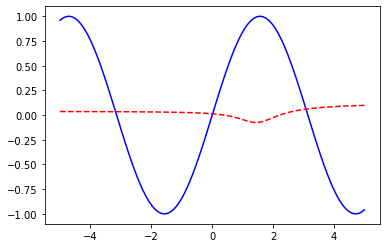

Loss: 42.87986755371094


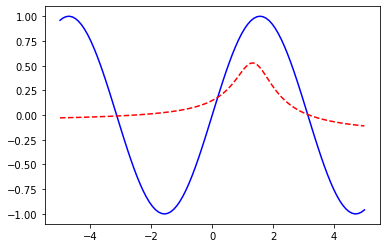

Loss: 34.390071868896484


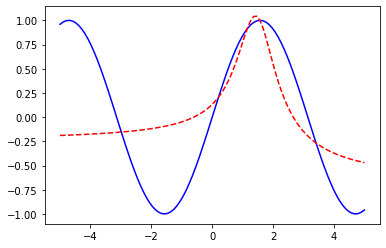

Loss: 29.84358787536621


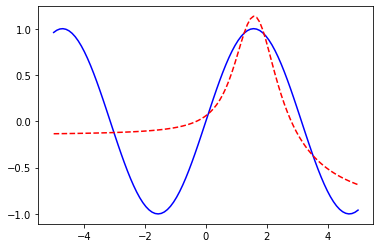

Loss: 25.37306022644043


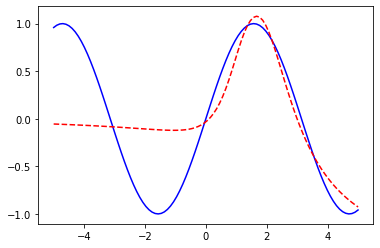

Loss: 15.29471206665039


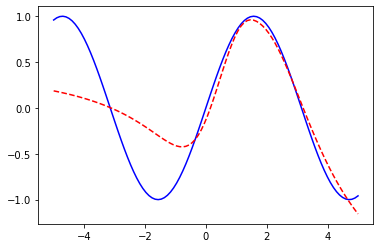

Loss: 1.721835970878601


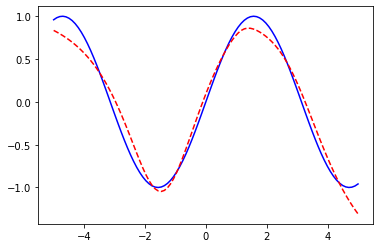

Loss: 0.3249237537384033


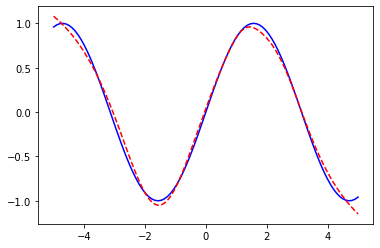

In [26]:

class PerceiverCell(nn.Module):
  def __init__(self, input_size: int, num_inputs: int, hidden_size: int, num_latents: int, embedding_size: int):
    super().__init__()
    self.hidden_init = nn.Parameter(torch.randn(1, num_latents, hidden_size))
    self.modality_embeddings = nn.Parameter(torch.randn(1, num_inputs, embedding_size))
    self.q_ln, self.kv_ln = nn.LayerNorm(hidden_size), nn.LayerNorm(input_size + embedding_size)
    self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=1, kdim=input_size + embedding_size, vdim=input_size + embedding_size, batch_first=True)
    self.cross_mlp = nn.Sequential(nn.LayerNorm(hidden_size), nn.Linear(hidden_size, hidden_size), nn.GELU(), nn.Linear(hidden_size, hidden_size))
    # self.self_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=1, batch_first=True)
    # self.self_mlp = nn.Sequential(nn.LayerNorm(hidden_size), nn.Linear(hidden_size, hidden_size), nn.GELU())

  def forward(self, input: Tensor, hidden: Optional[Tensor]) -> Tensor:
    # input of B x Modality x D; hidden of B x 1 x H
    if hidden is None: hidden = self.hidden_init
    input = self.kv_ln(torch.cat([input, self.modality_embeddings], dim=2))  # Concatenate embeddings and apply normalisation
    hidden = self.cross_attention(self.q_ln(hidden), input, input, need_weights=False)[0]  # Apply attention and unlike typical Pre-LN Transformer, do not apply residual
    hidden = self.cross_mlp(hidden) + hidden  # Apply MLP to each "object" in hidden (second dim) and add residual
    # hidden = self.self_attention(input, input, input, need_weights=False)
    # hidden = self.self_mlp(hidden)
    return hidden


D, M, H, L, E = 1, 1, 32, 2, 3
x = torch.linspace(-5, 5, 100).view(100, 1, D)  # T x B x D
y = x.sin()
# rnn = PerceiverCell(D, M, H, L, E)
rnn = Perceiver_GWT_GWWM(input_dim=1, num_latents=2, latent_dim=32, hidden_size=32, mod_embed=E)
regressor = nn.Linear(L * H, D * M)
optimiser = optim.AdamW(list(rnn.parameters()) + list(regressor.parameters()), lr=3e-4)

for epoch in range(200):
  h_t, y_t_hats, loss = None, [], 0
  optimiser.zero_grad()
  for x_t, y_t in zip(x, y):
    h_t_flat, h_t = rnn(x_t.unsqueeze(dim=1), h_t)  # Expand to M items
    # y_t_hat = regressor(h_t.mean(dim=1))  # Average over D latents
    y_t_hat = regressor(h_t_flat)  # Average over D latents
    loss += (y_t - y_t_hat).pow(2).mean()
    y_t_hats.append(y_t_hat.item())
  
  loss.backward()
  optimiser.step()
  if epoch % 25 == 0:
    print(f'Loss: {loss.item()}')
    plt.plot(x[:, 0, 0].numpy(), y[:, 0, 0].numpy(), 'b-', x[:, 0, 0].numpy(), np.array(y_t_hats), 'r--')
    plt.show()